In [52]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
import spacy

import transformer_lens
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [53]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [54]:
model_name = "gpt2-small"
# model_name = "gpt2-medium"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

HIDDEN_DIM = model.cfg.d_model

Loaded pretrained model gpt2-small into HookedTransformer


In [55]:
# Load the spaCy model
spacy_model = spacy.load("en_core_web_sm")

## Generate dataset

### Load text

In [56]:
# corpus = 'datasets/prewar.txt'
corpus = 'datasets/brown.dev'
with open(corpus, 'r') as f:
    raw_sentences = [line.rstrip("\n") for line in f.readlines()]

DATASET_CUTOFF = 10000
raw_sentences = raw_sentences[:DATASET_CUTOFF]
np.random.choice(raw_sentences, 5)

array(['Todman said over the radio as he came back up in formation .',
       "Such a pitiful end '' ! !", '`` Your fault , hell ! !',
       'The Old Man near the corner let the shadow pass over him , sensing something portentous in it .',
       'All my rosy visions of rest and even pleasure on this island vanished at the sight .'],
      dtype='<U754')

### Generating text sequences with labels (word index)

In [57]:
def map_word_index(text, prepend_bos=False):
    gpt_tokens = model.to_tokens(text, prepend_bos=prepend_bos).squeeze(0)
    gpt_tokens_str = [model.to_single_str_token(int(t)) for t in gpt_tokens]

    doc = spacy_model(str(text))
    word_idxs = [t.text for t in doc if t.is_alpha]

    if not len(word_idxs):
        return torch.Tensor(), []

    i = 0
    cur = 0 # current word index
    sub_idx = 0 # sub index of current word

    result = []
    while i < len(gpt_tokens_str):
        t = gpt_tokens_str[i].strip()
        # skip if token is just a newline or other whitespace
        if not len(t):
            result.append((t, i, -1))
            i += 1
            continue

        cur_word = word_idxs[cur]
        # if token is part of current word, update sub_idx, continue to next token
        if cur_word.find(t, sub_idx) != -1:
            result.append((t, i, cur))
            sub_idx += len(t)
            i += 1
        else:
            # if token not in cur_word, check next word
            if cur+1 < len(word_idxs) and t in word_idxs[cur+1]:
                cur += 1
                sub_idx = 0
            # if not in cur_word or next word, give up and continue
            else:
                result.append((t, i, -1))
                i += 1 

    return gpt_tokens, result

In [7]:
# check that map_word_index function is working correctly
# for s in tqdm(raw_sentences):
#     tokens, info = map_word_index(s)
#     assert len(tokens) == len(info)

In [58]:
SEQ_LEN = 500

def generate_seq():
    tokens = model.to_tokens("\n", prepend_bos=True).squeeze(0)
    info = [("\n", 0, -1)]

    while len(tokens) < SEQ_LEN:
        next_t, next_info = map_word_index(np.random.choice(raw_sentences))
        if len(next_t):
            tokens = torch.cat((tokens, next_t))
            info.extend(next_info)

    word_idx = np.array(list(map(lambda x: x[2], info)))
    return tokens, word_idx

tokens, word_idx = generate_seq()
np.unique(word_idx, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35]),
 array([85, 38, 30, 29, 29, 26, 27, 27, 21, 20, 16, 18, 14, 13, 14, 11, 11,
        10,  8, 10,  9,  7,  6,  6,  6,  4,  4,  5,  3,  3,  3,  2,  2,  2,
         2,  2,  1]))

### Generate Embeddings

In [59]:
N_SEQS = 1000
# cutoff initial tokens because model behavior is weird there
PREFIX_CUTOFF = 50

torch.set_grad_enabled(False)

all_resids = []
all_word_idx = []

for i_batch in tqdm(range(N_SEQS)):
    tokens, word_idx = generate_seq()
    # make sure tokens doesn't exceed GPT2's context length
    tokens = tokens[:1000]

    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, 0, PREFIX_CUTOFF+1:, :]
    word_idx = word_idx[PREFIX_CUTOFF:]

    assert residuals.shape[1] == word_idx.shape[0]

    # this mask excludes puncuation and word fragments
    mask = word_idx != -1

    all_resids.append(residuals.cpu().numpy()[:, mask])
    all_word_idx.append(word_idx[mask])



100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


In [60]:
x_all_layers = np.concatenate(all_resids, axis=1)
y_all = np.concatenate(all_word_idx)

print(x_all_layers.shape)
print(y_all.shape)

(12, 367251, 768)
(367251,)


In [75]:
N_BUCKETS = 20
percentile_buckets = [(100 // N_BUCKETS) * i for i in range(1, N_BUCKETS)]
cutoffs = np.percentile(y_all, percentile_buckets)
q_binned = np.searchsorted(cutoffs, y_all, side='right')

print(cutoffs)

[ 0.  1.  1.  2.  3.  4.  4.  5.  6.  7.  8.  9. 10. 12. 13. 15. 18. 21.
 27.]


### filter data

In [76]:
LAYER = 2

X = x_all_layers[LAYER, :]
Y = q_binned

print(X.shape)
print(Y.shape)

(367251, 768)
(367251,)


## Training Probes

In [77]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [88]:
probing_dataset = ProbingDataset(X, Y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 367251 pairs loaded...
y: (array([ 1,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), array([30895, 27729, 25979, 25058, 23300, 21705, 20247, 18623, 17028,
       15768, 28111, 11934, 20624, 23760, 16810, 20120, 19560]))
split into [test/train], [73451/293800]


In [89]:
probe = LinearProbe(device, HIDDEN_DIM, len(np.unique(Y)))

EXPERIMENT_NAME = f"brown_{N_BUCKETS}qbin_366k"
folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
if os.path.isdir(folder):
    print(f"Warning, {folder} already exists")
config = TrainerConfig(num_epochs=20, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [90]:
trainer.train()

Epoch 0; no stats yet:   0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [82]:
print(trainer.generate_report())

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### plotting loss curves

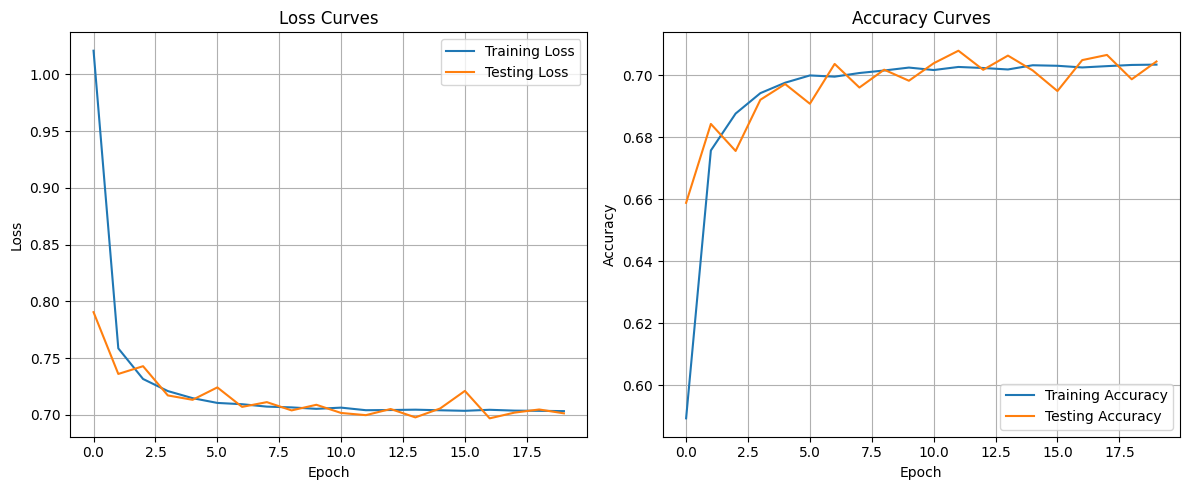

In [49]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### training on all layers

In [59]:
for LAYER in range(x_all_layers.shape[0]):
    print(f"LAYER: {LAYER}")
    X = x_all_layers[LAYER, :]

    probing_dataset = ProbingDataset(X, Y)
    train_size = int(0.8 * len(probing_dataset))
    test_size = len(probing_dataset) - train_size
    probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

    probe = LinearProbe(device, HIDDEN_DIM, len(np.unique(Y)))

    EXPERIMENT_NAME = f"prewar_{N_BUCKETS}qbin_425k"
    folder = f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{LAYER}"
    if os.path.isdir(folder):
        print(f"Warning, {folder} already exists")
    config = TrainerConfig(num_epochs=20, ckpt_path=folder)
    trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

    trainer.train()

LAYER: 0
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.83952; Train Acc: 30.759%; Test Acc: 30.706%: 100%|██████████| 20/20 [02:03<00:00,  6.18s/it]


LAYER: 1
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.50658; Train Acc: 40.624%; Test Acc: 39.540%: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


LAYER: 2
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.36533; Train Acc: 44.917%; Test Acc: 44.711%: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


LAYER: 3
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.37073; Train Acc: 44.926%; Test Acc: 44.669%: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


LAYER: 4
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.33381; Train Acc: 45.876%; Test Acc: 45.453%: 100%|██████████| 20/20 [02:03<00:00,  6.16s/it]


LAYER: 5
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.30361; Train Acc: 46.558%; Test Acc: 46.863%: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


LAYER: 6
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.31576; Train Acc: 46.171%; Test Acc: 45.631%: 100%|██████████| 20/20 [02:05<00:00,  6.25s/it]


LAYER: 7
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.36286; Train Acc: 44.384%; Test Acc: 44.286%: 100%|██████████| 20/20 [02:04<00:00,  6.23s/it]


LAYER: 8
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.46010; Train Acc: 41.489%; Test Acc: 41.067%: 100%|██████████| 20/20 [02:03<00:00,  6.19s/it]


LAYER: 9
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.58281; Train Acc: 37.902%; Test Acc: 37.037%: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


LAYER: 10
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.70084; Train Acc: 34.789%; Test Acc: 34.483%: 100%|██████████| 20/20 [02:04<00:00,  6.24s/it]


LAYER: 11
dataset: 425028 pairs loaded...
y: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([38709, 37441, 48172, 44650, 40265, 43919, 42377, 41368, 45358,
       42769]))


Epoch 20; Train Loss: 1.84143; Train Acc: 31.609%; Test Acc: 32.026%: 100%|██████████| 20/20 [02:03<00:00,  6.20s/it]


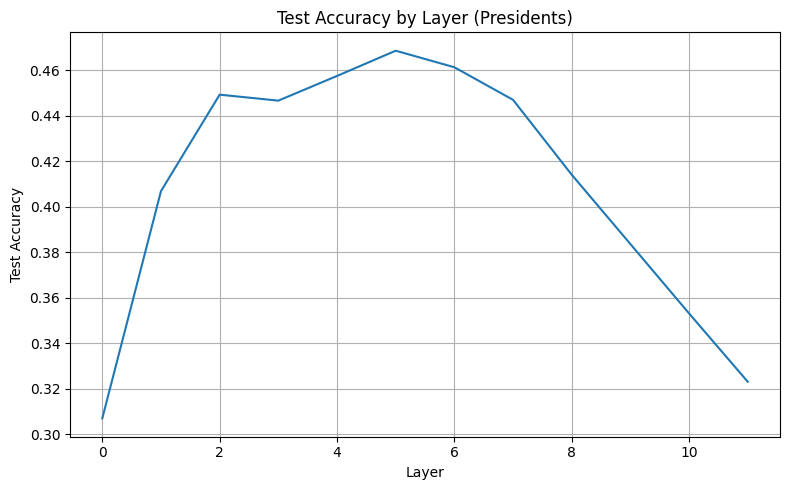

In [62]:
by_layer = []
for i in range(12):
    with open(f"ckpts/{model_name}/{EXPERIMENT_NAME}/layer{i}/metrics.json", 'r') as f:
        metrics = json.load(f)['metrics']
        best = max(metrics['test_acc'])
        by_layer.append(best)

plt.figure(figsize=(8, 5))

plt.plot(by_layer)
plt.title('Test Accuracy by Layer (Presidents)')
plt.xlabel('Layer')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()